# Wasserstein GAN: An Annotated Implementation
*Deep Learning Final Project*

***Authors:***
- *Alberto Mateo*
- *Anna Monso*
- *Judit Martín Sesé*
- *Hernan Garcia Quijano*

---

## Introduction: Why Wasserstein?

[cite_start]*Generative Adversarial Networks (GANs) have demonstrated impressive results in unsupervised learning, yet they are notoriously difficult to train*[cite: 34]. [cite_start]*Standard GAN training is "delicate and unstable," often requiring a precise balance between the discriminator and generator to prevent vanishing gradients or mode collapse*[cite: 34, 53].

The paper ***"Wasserstein GAN"*** (Arjovsky et al., 2017) argues that these issues stem from the choice of distance metric used to measure the gap between the real data distribution ($\mathbb{P}_r$) and the model distribution ($\mathbb{P}_\theta$). [cite_start]*Traditional approaches, which often optimize proxies for the Kullback-Leibler (KL) or Jensen-Shannon (JS) divergences, fail when these distributions are supported by low-dimensional manifolds that do not overlap* [cite: 14-17]. [cite_start]*In these disjoint cases, the gradient often vanishes or becomes undefined, halting learning*[cite: 17, 198].

### The Solution: Earth-Mover Distance
The authors propose using the ***Earth-Mover (EM) distance*** (also known as Wasserstein-1). [cite_start]*Intuitively, if we view probability distributions as piles of earth, the EM distance is the minimum cost to transport the mass from one pile to match the other* [cite: 73-74].

[cite_start]*Unlike JS or KL divergences, the EM distance is continuous and differentiable almost everywhere, even when distributions are disjoint* [cite: 81, 112-114]. [cite_start]*This provides smooth, usable gradients for the generator throughout the training process*[cite: 124, 201].

### Key Contributions Annotated in this Project
In this notebook, we implement the ***WGAN*** algorithm to demonstrate its two primary claims:
1.  [cite_start]***A Meaningful Loss Metric:*** *We show that the WGAN critic's loss correlates with sample quality, allowing for easier debugging and hyperparameter search* [cite: 54-55, 235].
2.  [cite_start]***Improved Stability:*** *We demonstrate that WGANs are robust to architectural choices and do not require the delicate balancing of generator and discriminator capacities typical of standard GANs*[cite: 52, 342].

### 1. Setup and Configuration

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, utils
import numpy as np
import matplotlib.pyplot as plt

# Configuration based on WGAN Paper Algorithm 1
config = {
    "learning_rate": 0.00005,      # Paper uses alpha = 0.00005 
    "clip_value": 0.01,            # Clipping parameter c = 0.01 
    "batch_size": 64,              # Batch size m = 64 
    "n_critic": 5,                 # Critic iterations per generator iter = 5 
    "z_dim": 2,                    # Latent dimension (kept small for CPU visualization)
    "input_dim": 2,                # Real data dimension (2D for easy viz)
    "hidden_dim": 64,              # Small capacity for CPU speed
}

## 2. Model Architecture (Analysis & Synthesis)

This section explains the architecture of the Wasserstein GAN, breaking the model into its individual components and then synthesizing how they work together to approximate and minimize the Earth Mover distance. All explanations follow the structure of the WGAN paper.

---

#### 2.1 Analysis: Generator and Critic Architectures

##### Generator Architecture

The generator implements the mapping \( g_\theta : Z \to X \), transforming noise vectors into synthetic samples. The paper validates that simple MLPs perform well under the Wasserstein loss, even with small hidden layers.

**Diagram of the Generator**

**Analysis:** 

![Analysis Diagram](Analysis_diagram.png)


The generator implements the mapping gθ: Z → X described in Section 3 of the WGAN paper. 

In the experiments the authors validate that even simple MLPs with ReLU activations are sufficient when using the Wasserstein objective. We use a smaller version of their 4 layer MLP with 512 units, scaled down to 64 units for CPU feasibility.

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Simple MLP Generator
        self.net = nn.Sequential(
            nn.Linear(config["z_dim"], config["hidden_dim"]),
            nn.ReLU(True),
            nn.Linear(config["hidden_dim"], config["hidden_dim"]),
            nn.ReLU(True),
            nn.Linear(config["hidden_dim"], config["input_dim"]),
            # No Sigmoid here because we are generating raw data (R^2 space)
        )

    def forward(self, z):
        return self.net(z)

#### Critic Architecture:



The critic implements the function class f_w that approximates the supremum in the Kantorovich Rubinstein dual formulation of the Earth Mover distance (Section 3, equation (2)) .

The key architectural rule is that the critic outputs a real valued score and therefore does not have a sigmoid output. This is consistent with Figure 2 and Algorithm 1 in the paper.

![Critic Diagram](Critic_diagram.png)


In [4]:


class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        # Simple MLP Critic (formerly Discriminator)
        self.net = nn.Sequential(
            nn.Linear(config["input_dim"], config["hidden_dim"]),
            nn.ReLU(True),
            nn.Linear(config["hidden_dim"], config["hidden_dim"]),
            nn.ReLU(True),
            nn.Linear(config["hidden_dim"], 1) 
            # CRITICAL: No Sigmoid at the output! 
            # The output is a scalar score, not a probability.
        )

    def forward(self, x):
        return self.net(x)

---

#### 2.2 Enforcing the 1 Lipschitz constraint:


The WGAN critic must satisfy a 1 Lipschitz condition in order for the dual formulation of the Earth Mover distance to hold. The paper uses the Kantorovich Rubinstein duality, which expresses the Wasserstein 1 distance as

\[
W(P_r, P_\theta)
=
\sup_{f \,\text{is 1-Lipschitz}}
\left[
\mathbb{E}_{x \sim P_r}[f(x)]
-
\mathbb{E}_{x \sim P_\theta}[f(x)]
\right].
\]

Because the supremum is taken over all 1 Lipschitz functions, the critic \( f_w \) must be constrained so that its gradients do not grow without bound. WGAN enforces this constraint through **weight clipping**, which is simple, efficient, and directly follows Algorithm 1.


##### Weight Clipping

After every critic gradient update, all parameters \( w \) are projected into a fixed interval:

\[
w \leftarrow \text{clip}(w,\,-c,\,c).
\]

This forces the critic to lie in a compact subset of parameter space, which guarantees it is \( K \) Lipschitz for some constant \( K \) determined by the clipping value \( c \). Although crude, this approximation is sufficient for the dual formulation to hold and for the Wasserstein estimate to remain stable.

**Diagram**

![Lipschitz Diagram](Lipschitz_constrain_diagram.png)


---

### 2.3 Loss Functions

The Wasserstein GAN replaces the traditional GAN losses with objectives that arise directly from the dual formulation of the Earth Mover distance. Section 3 of the paper defines the critic objective in equation (3) and the generator objective in Algorithm 1.

#### Critic Loss

The critic approximates the function class required by the Kantorovich Rubinstein dual formulation. The loss it maximizes is given in equation (3) on page 7:

\[
\max_w \; \mathbb{E}_{x \sim P_r} [f_w(x)] \;-\; \mathbb{E}_{z \sim p(z)} [f_w(g_\theta(z))].
\]

When training, we convert this maximization into a minimization by negating the expression, so the critic loss becomes

\[
L_{\text{critic}} = -\left( 
\mathbb{E}_{x \sim P_r}[f_w(x)] \;-\; 
\mathbb{E}_{z \sim p(z)}[f_w(g_\theta(z))]
\right).
\]

**How this is computed in code**

* The first expectation, \( \mathbb{E}_{x \sim P_r}[f_w(x)] \), is computed by passing a batch of real data through the critic and taking the mean of the critic outputs.
* The second expectation, \( \mathbb{E}_{z \sim p(z)}[f_w(g_\theta(z))] \), is computed by sampling noise vectors \(z\), generating fake samples \(g_\theta(z)\), passing those samples through the critic, and taking the mean.
* The loss is the difference between these means, with a negative sign so that gradient descent performs the maximization required by the dual formulation.

This directly matches the objective written in the paper and ensures that the critic approximates the Wasserstein distance between real and generated distributions.



#### Generator Loss

Algorithm 1 (line 10) defines the generator update step as

\[
g_\theta \leftarrow -\nabla_\theta \frac{1}{m} \sum_{i=1}^m f_w(g_\theta(z^{(i)})).
\]

This corresponds to minimizing the following generator loss:

\[
L_{\text{gen}} = - \mathbb{E}_{z \sim p(z)}[f_w(g_\theta(z))].
\]

**Why there are no log terms**

Traditional GANs optimize a Jensen Shannon based objective, which involves log D(x) and log(1 minus D(g(z))). WGAN removes the discriminator as a classifier and replaces it with a critic that outputs unrestricted real values. The critic no longer predicts probabilities, so there is no need for a sigmoid or logarithmic likelihood terms.

**Why the generator is not trying to fool the critic**

In a classical GAN, the generator tries to make the discriminator classify fake samples as real. In WGAN, the generator has a different role. It simply tries to reduce the critic score of its fake samples. Since the critic score approximates the Wasserstein distance, minimizing this value pushes the generated distribution closer to the real one in terms of optimal transport. There is no adversarial classification involved, only the minimization of an estimated distance.



These losses together form the core of the WGAN training dynamics. The critic estimates the Wasserstein distance and the generator minimizes that estimate, producing a stable gradient even when the support of the distributions is disjoint.


---

#### 2.4 Training loop architecture 

The WGAN training loop follows Algorithm 1 from the paper. The key idea is that the critic must be trained several times for every generator update, so it can closely approximate the supremum in the dual formulation of the Earth Mover distance. Below is a flow style reconstruction of Algorithm 1.

##### Explanation of Each Step

##### 1. ncritic critic updates

The paper sets `ncritic = 5` for most experiments. This means the critic is updated several times before each generator step.

**Sample real batch**  
A minibatch of real data \( x^{(i)} \sim P_r \) is drawn.  
The critic processes these samples to compute \( f_w(x) \).

**Sample noise batch**  
Sample \( z^{(i)} \sim p(z) \) from a simple prior (typically Gaussian or uniform).  
Pass them through the generator to obtain fake data \( g_\theta(z) \).

**Compute critic loss**  
The critic uses the loss derived from equation (3) in the paper:

\[
L_{\text{critic}} = -\left(
\mathbb{E}_{x \sim P_r}[f_w(x)] -
\mathbb{E}_{z \sim p(z)}[f_w(g_\theta(z))]
\right).
\]

The critic tries to maximize the difference between scores on real and fake samples.  
We multiply by minus one so gradient descent performs this maximization.

**Update critic parameters**  
A gradient update step is applied with RMSProp, following Algorithm 1.

**Clip critic weights**  
After each update, all critic weights are clipped to lie inside \([−c, c]\).  
The paper enforces this constraint to keep the critic K Lipschitz, which is required by the Kantorovich Rubinstein dual form of the Wasserstein distance.


##### 2. One generator update

After `ncritic` critic updates, the generator is updated a single time.

**Sample noise batch**  
Draw a fresh batch \( z^{(i)} \sim p(z) \).

**Compute generator loss**

According to Algorithm 1 (line 10):

\[
L_{\text{gen}} = -\mathbb{E}_{z \sim p(z)}[f_w(g_\theta(z))].
\]

This loss encourages the generator to produce samples that increase the critic score, which reduces the estimated Earth Mover distance between the model and real distributions.

**Update generator parameters**  
One gradient descent step is applied to the generator.  
Importantly, no clipping is applied to the generator.



##### Annotated Training Loop in Code

```python
for _ in range(num_iterations):

    # --- Critic updates ---
    for _ in range(n_critic):
        real = sample_real_batch(batch_size)
        z = sample_noise(batch_size)
        fake = generator(z).detach()  # stop gradients to generator

        critic_real = critic(real)
        critic_fake = critic(fake)

        loss_critic = -(critic_real.mean() - critic_fake.mean())

        critic_optimizer.zero_grad()
        loss_critic.backward()
        critic_optimizer.step()

        # Enforce 1-Lipschitz constraint
        for p in critic.parameters():
            p.data.clamp_(-c, c)

    # --- Generator update ---
    z = sample_noise(batch_size)
    fake = generator(z)

    loss_gen = -critic(fake).mean()

    generator_optimizer.zero_grad()
    loss_gen.backward()
    generator_optimizer.step()




---

### 2.5 Synthesis: How the Parts Come Together

The full WGAN pipeline combines the generator, critic, loss functions, and training loop into a single system that approximates and minimizes the Earth Mover distance between the real distribution \(P_r\) and the model distribution \(P_\theta\). The diagram below summarizes the flow of information through the model.


![Synthesis_diagram](Synthesis_diagram.png)


#### Unified Explanation

1. **Generator produces fake samples**  
   Noise vectors \( z \sim p(z) \) are transformed by the generator into fake data \( g_\theta(z) \).  
   These samples represent the model distribution \(P_\theta\).

2. **Critic processes both real and fake data**  
   The critic \( f_w \) outputs real valued scores for:
   * real data \( f_w(x) \)
   * fake data \( f_w(g_\theta(z)) \)

   Since the critic has no sigmoid, its output is a scalar that can freely increase or decrease to approximate the optimal Kantorovich potential.

3. **Critic estimates the Wasserstein distance**  
   The critic maximizes the expression

   \[
   \mathbb{E}_{x \sim P_r}[f_w(x)] - \mathbb{E}_{z \sim p(z)}[f_w(g_\theta(z))].
   \]

   This is exactly the dual form of the Earth Mover distance from equation (2) in the paper:

   \[
   W(P_r, P_\theta) = 
   \sup_{f \,\text{is 1-Lipschitz}} 
   \left( 
   \mathbb{E}_{x \sim P_r}[f(x)] 
   - \mathbb{E}_{x \sim P_\theta}[f(x)]
   \right).
   \]

   Weight clipping ensures \( f_w \) remains in a K Lipschitz function class.

4. **Critic is updated multiple times**  
   To approximate the supremum in the dual formulation, the critic is trained for `ncritic` steps before each generator update.  
   This allows it to closely estimate the Wasserstein distance.

5. **Generator is updated once per cycle**  
   After the critic is near optimal for its current parameters, the generator performs one update to minimize

   \[
   L_{\text{gen}} = -\mathbb{E}_{z \sim p(z)}[f_w(g_\theta(z))].
   \]

   Reducing this value means reducing the critic’s estimate of the EM distance, which pushes the generated distribution toward the real one.

6. **Gradients flow through the critic into the generator**  
   Although the critic is not trained during the generator update, its gradients provide the direction in which the generator must move to decrease the Wasserstein distance.


#### How the Pipeline Implements Optimal Transport

The entire system forms a neural approximation of the optimal transport problem. The critic attempts to solve the dual formulation of the Earth Mover distance by learning a 1-Lipschitz function that best separates real and fake data. The generator then moves samples in the direction that reduces this separation.

As the training loop alternates:
* the critic estimates \( W(P_r, P_\theta) \),
* the generator minimizes that estimate.

This creates an end to end procedure in which gradient based optimization performs stochastic descent on the Wasserstein distance itself. The result is a stable learning process with meaningful, smooth gradients that do not vanish even when the real and model distributions initially lie on disjoint low dimensional manifolds.



This completes the Synthesis section and ties together all architectural and theoretical components of WGAN.



### 3. The WGAN Training Mechanics
This section implements the core mathematical contributions.Weight ClippingTo approximate the Earth Mover distance, the function must be 1-Lipschitz. The paper achieves this by clamping weights to a fixed box $[-\tilde{c}, c]$5.

In [5]:
def clip_weights(model, clip_value):
    """
    Enforce Lipschitz constraint by clipping weights.
    Paper: 'w <- clip(w, -c, c)' [cite: 190]
    """
    for p in model.parameters():
        p.data.clamp_(-clip_value, clip_value)

Initialization 

The paper notes that momentum-based optimizers like Adam can be unstable for the critic because the loss is non-stationary. They suggest RMSProp.

In [6]:
# Initialize models
G = Generator()
C = Critic()

# Use RMSProp as suggested in the paper 
# "We therefore switched to RMSProp which is known to perform well..."
optimizer_G = optim.RMSprop(G.parameters(), lr=config["learning_rate"])
optimizer_C = optim.RMSprop(C.parameters(), lr=config["learning_rate"])

### The Training Loop (Annotated)
This strictly follows the loop in Algorithm 1.

#### 3.1 Training objective and loss functions

The goal of WGAN is to minimise the Wasserstein distance between the real distribution $P_r$ and the model distribution $P_g$.  
This is implemented through two networks:

- a **critic** $C$, which assigns a real-valued score to each sample, and  
- a **generator** $G$, which maps latent noise $z \sim p(z)$ to fake samples $G(z)$.

In our implementation, we sample $z$ from a standard normal distribution (i.e., $p(z)=\mathcal{N}(0,I)$).

---

##### Critic objective

The critic is trained to maximise the gap between the average score of real and fake samples:

$$
\max_C \ \mathbb{E}_{x \sim P_r}[C(x)] - \mathbb{E}_{z \sim p(z)}[C(G(z))].
$$

Since we use gradient **descent**, we minimise the negative of this quantity:

$$
L_C = -\Big( \mathbb{E}_{x \sim P_r}[C(x)] - \mathbb{E}_{z \sim p(z)}[C(G(z))] \Big).
$$

In code this appears as:

```python
loss_c = -(torch.mean(C(real_data)) - torch.mean(C(fake_data)))
```

Note: for the Wasserstein formulation to be valid, the critic should be approximately 1-Lipschitz. In the original WGAN, this is enforced using weight clipping, which we apply after each critic update.

In [7]:
def get_real_data(batch_size):
    """
    Generates a batch of real data: a Gaussian centered at (4, 4).
    This acts as our 'Real Distribution' P_r.
    """
    return torch.randn(batch_size, 2) + 4

Starting training...
Iter 0: Wasserstein Dist Estimate: 0.0002
Iter 200: Wasserstein Dist Estimate: 0.0061
Iter 400: Wasserstein Dist Estimate: 0.0045
Iter 600: Wasserstein Dist Estimate: 0.0020
Iter 800: Wasserstein Dist Estimate: 0.0001
Iter 1000: Wasserstein Dist Estimate: 0.0003
Iter 1200: Wasserstein Dist Estimate: 0.0004
Iter 1400: Wasserstein Dist Estimate: 0.0003
Iter 1600: Wasserstein Dist Estimate: 0.0001
Iter 1800: Wasserstein Dist Estimate: 0.0001


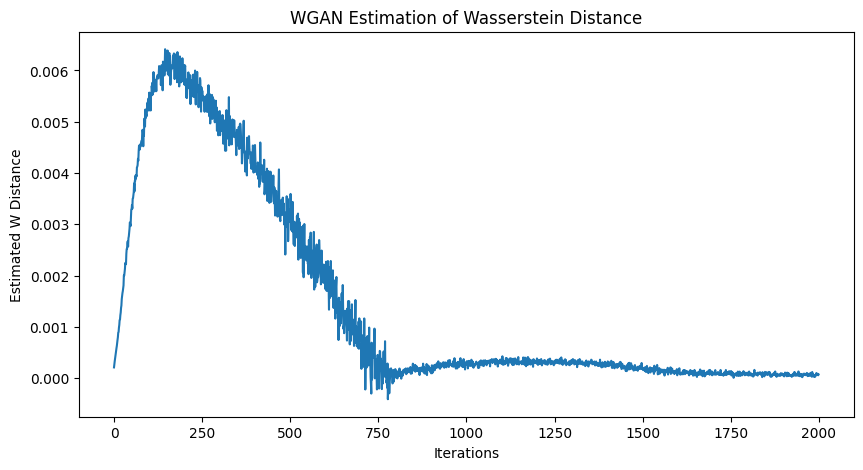

In [ ]:
losses_g = []
losses_c = []
w_distances = []

print("Starting training...")

for iteration in range(2000): # Keep iterations low for MWE
    
    #  1. Train the Critic (n_critic times)
    for _ in range(config["n_critic"]):
        
        # Sample real data x ~ P_r [cite: 187]
        real_data = get_real_data(config["batch_size"])
        
        # Sample latent z ~ p(z) [cite: 187]
        z = torch.randn(config["batch_size"], config["z_dim"])
        fake_data = G(z).detach() # Detach so we don't backprop to G yet
        
        # Critic Loss: -(Mean(D(real)) - Mean(D(fake)))
        # We want to maximize the gap, so we minimize the negative gap.
        # See Eq (2) and Algorithm 1, Line 5 [cite: 147, 188]
        loss_c = -(torch.mean(C(real_data)) - torch.mean(C(fake_data)))
        
        optimizer_C.zero_grad()
        loss_c.backward()
        optimizer_C.step()
        
        # Clip weights to ensure Lipschitz constraint [cite: 190]
        clip_weights(C, config["clip_value"])
        
    #  2. Train the Generator (1 time)
    
    # Sample latent z ~ p(z) [cite: 192]
    z = torch.randn(config["batch_size"], config["z_dim"])
    
    # Generator Loss: -Mean(D(G(z)))
    # The generator wants to maximize the critic's output for its fake data.
    # See Algorithm 1, Line 10 [cite: 192]
    loss_g = -torch.mean(C(G(z)))
    
    optimizer_G.zero_grad()
    loss_g.backward()
    optimizer_G.step()
    
    # Store metrics
    losses_c.append(loss_c.item())
    losses_g.append(loss_g.item())
    # The negative critic loss approximates the Wasserstein distance
    w_distances.append(-loss_c.item())

    if iteration % 200 == 0:
        print(f"Iter {iteration}: Wasserstein Dist Estimate: {-loss_c.item():.4f}")

# Plotting the "Meaningful Loss Metric" [cite: 235]
plt.figure(figsize=(10,5))
plt.title("WGAN Estimation of Wasserstein Distance")
plt.plot(w_distances)
plt.xlabel("Iterations")
plt.ylabel("Estimated W Distance")
plt.show()

#### 3.2 Training loop

The training loop follows Algorithm 1 from the WGAN paper. At a high level, each iteration alternates between:

1. **Several critic updates** (to keep the critic near its optimum for the current generator), and  
2. **One generator update** (using the critic as a learned loss function).

In our implementation (see `config`), we use `n_critic = 5`, `clip_value = 0.01`, `batch_size = 64`, and `learning_rate = 5e-5`.

Concretely, for each iteration we do:

**1. Update the critic `n_critic` times**

For each critic step:

- **Sample real data**  
  We draw a batch of points from our “real” distribution $P_r$ using `get_real_data(batch_size)`.  
  In our case, $P_r$ is a 2D Gaussian centred around $(4, 4)$.

- **Sample fake data**  
  We sample latent noise $z \sim \mathcal{N}(0, I)$ and transform it with the generator to obtain fake samples $\tilde{x} = G(z)$.  
  We call .detach() so that when training the critic, gradients do not flow into the generator. This cleanly separates the critic update from the generator update.

- **Compute the critic loss and update critic parameters**  
  The critic is trained to assign higher scores to real samples and lower scores to fake samples. 
  We maximise the score gap between real and fake
  $$
  \mathbb{E}[C(x)] - \mathbb{E}[C(\tilde{x})],
  $$
  which, in code, is implemented by *minimizing* its negative:
  loss_c = -(torch.mean(C(real_data)) - torch.mean(C(fake_data)))
  
  We use RMSProp (as suggested in the paper) for critic optimization:
  optimizer_C = optim.RMSprop(C.parameters(), lr=config["learning_rate"])

- **Lipschitz constraint via weight clipping (regularization / training trick)**
  After each critic update we apply clip_weights(C, clip_value). This clamps all critic weights into [-clip_value, +clip_value] (in our case [-0.01, 0.01]). This is the original WGAN paper’s practical strategy to approximately enforce the 1-Lipschitz constraint required for the Wasserstein formulation.

Repeating this inner loop n_critic times makes the critic a reasonably good approximation of the optimal Kantorovich critic for the current generator.


**2. Update the generator once**

After the critic has been updated n_critic times, we update the generator once.
- We sample a fresh batch of noise z and generate fake samples G(z).
- We evaluate them with the critic and compute the generator loss

$$
L_G = -\mathbb{E}[C(G(z))]
$$

In code:
```python
loss_g = -torch.mean(C(G(z)))
optimizer_G.zero_grad()
loss_g.backward()
optimizer_G.step()
```

We backpropagate this loss and update the generator with RMSProp. Intuitively, the generator is rewarded when the critic assigns high scores to its fake samples, so over time the generator distribution $P_g$ moves closer to the real data distribution $P_r$.


**3. Recorded metrics and observed behaviour**

During training, we stored:

- `losses_c`: the critic loss at each iteration,
- `losses_g`: the generator loss at each iteration,
- `w_distances`: an estimate of the Wasserstein distance, computed and stored as:

w_distances.append(-loss_c.item())

We also print the estimate periodically and plot `w_distances`. In our run, the Wasserstein estimate is initially noisy (the critic is still learning), then decreases and flattens near a small value. This matches the expected WGAN behaviour: as training progresses, the generator improves and the critic perceives less separation between real and generated samples.



### 4. Minimal CPU-Ready Data (Synthetic)

In this section we implement a small Wasserstein GAN (WGAN) on a tiny subset of the MNIST dataset.

Goals:
- Use a small real-world dataset (MNIST digits).
- Build a miniaturized WGAN (small MLP generator and critic) that runs on CPU.
- Train the model and analyze the training process and outcomes (not focusing on state-of-the-art performance, but on understanding the behavior).

In [9]:
torch.manual_seed(0)
np.random.seed(0)

In [10]:
# Data & model hyperparameters
img_size = 28
img_dim = img_size * img_size
z_dim = 64          # dimension of the noise vector
hidden_dim = 128    # hidden layer width in generator and critic

# Training hyperparameters 
batch_size = 128
lr = 5e-5
n_epochs = 20       
n_critic = 5        # number of critic updates per generator update 
clip_value = 0.01   # weight clipping for critic

device = torch.device("cpu")  
device

device(type='cpu')

In [11]:
# Transform: convert to tensor and normalize to [0, 1]
transform = transforms.ToTensor()

# Load original MNIST train set
mnist_train = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

# Keep only digits 0 and 1 to make the task simpler
targets = mnist_train.targets  
mask = (targets == 0) | (targets == 1)
indices = torch.nonzero(mask, as_tuple=False).squeeze()

# Take only first 5000 examples of digits 0 and 1
max_samples = 5000
indices = indices[:max_samples]

mnist_small = Subset(mnist_train, indices)

train_loader = DataLoader(
    mnist_small,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=0
)

len(mnist_small), len(train_loader)


(5000, 39)

Batch shape: torch.Size([128, 1, 28, 28])


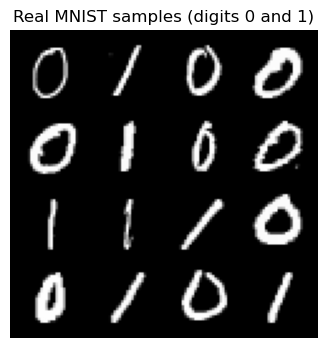

In [12]:
# Get a single batch
real_imgs, real_labels = next(iter(train_loader))

print("Batch shape:", real_imgs.shape)  # (batch_size, 1, 28, 28)

# Show a grid of real images
grid = utils.make_grid(real_imgs[:16], nrow=4, padding=2)
plt.figure(figsize=(4, 4))
plt.imshow(grid.permute(1, 2, 0), cmap="gray")
plt.axis("off")
plt.title("Real MNIST samples (digits 0 and 1)")
plt.show()


In [13]:
class Generator(nn.Module):
    def __init__(self, z_dim=64, img_dim=28*28, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, img_dim),
            nn.Sigmoid()  # output in [0,1] to match MNIST scaling
        )

    def forward(self, z):
        x = self.net(z)                   # shape: (batch_size, img_dim)
        x = x.view(-1, 1, 28, 28)         # reshape to image format
        return x


In [14]:
class Critic(nn.Module):
    def __init__(self, img_dim=28*28, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1)   
        )

    def forward(self, img):
        x = img.view(img.size(0), -1)  # flatten image
        out = self.net(x)
        return out


In [15]:
generator = Generator(z_dim=z_dim, img_dim=img_dim, hidden_dim=hidden_dim).to(device)
critic = Critic(img_dim=img_dim, hidden_dim=hidden_dim).to(device)

opt_g = optim.RMSprop(generator.parameters(), lr=lr)
opt_c = optim.RMSprop(critic.parameters(), lr=lr)

print(generator)
print(critic)


Generator(
  (net): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Sigmoid()
  )
)
Critic(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [16]:
def sample_z(batch_size, z_dim, device):
    return torch.randn(batch_size, z_dim, device=device)


In [17]:
def critic_step(critic, generator, real_imgs, opt_c, clip_value):
    critic.train()
    generator.eval()

    batch_size = real_imgs.size(0)
    real_imgs = real_imgs.to(device)

    # Sample fake images from generator
    z = sample_z(batch_size, z_dim, device)
    fake_imgs = generator(z).detach()  # detach: do not backprop into G here

    # Critic scores
    critic_real = critic(real_imgs)
    critic_fake = critic(fake_imgs)

    # WGAN critic loss: negative of Wasserstein estimate
    loss_c = -(critic_real.mean() - critic_fake.mean())

    opt_c.zero_grad()
    loss_c.backward()
    opt_c.step()

    # Weight clipping for Lipschitz constraint
    for p in critic.parameters():
        p.data.clamp_(-clip_value, clip_value)

    # For logging
    wasserstein_est = (critic_real.mean() - critic_fake.mean()).item()

    return loss_c.item(), wasserstein_est


In [18]:
def generator_step(critic, generator, opt_g, batch_size):
    critic.eval()
    generator.train()

    z = sample_z(batch_size, z_dim, device)
    fake_imgs = generator(z)
    critic_fake = critic(fake_imgs)

    # WGAN generator loss
    loss_g = -critic_fake.mean()

    opt_g.zero_grad()
    loss_g.backward()
    opt_g.step()

    return loss_g.item()


Epoch [1/20] Critic loss: -1.0454  Generator loss: 0.6844  Wasserstein estimate: 1.0454


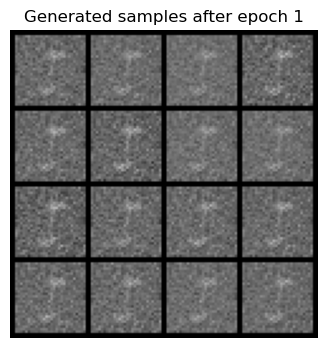

Epoch [2/20] Critic loss: -1.1876  Generator loss: 0.7224  Wasserstein estimate: 1.1876


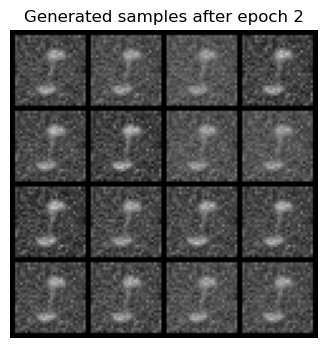

Epoch [3/20] Critic loss: -0.9085  Generator loss: 0.4975  Wasserstein estimate: 0.9085


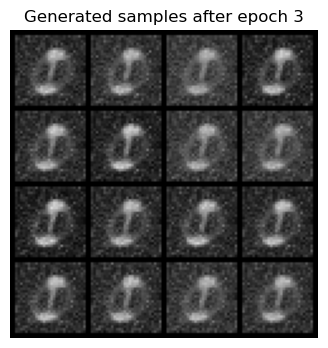

Epoch [4/20] Critic loss: -0.5785  Generator loss: 0.3487  Wasserstein estimate: 0.5785


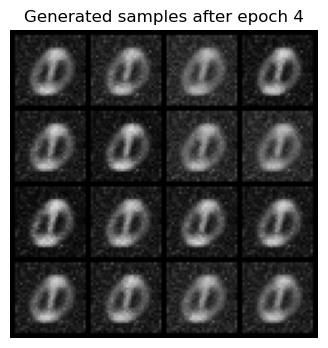

Epoch [5/20] Critic loss: -0.3770  Generator loss: 0.2632  Wasserstein estimate: 0.3770


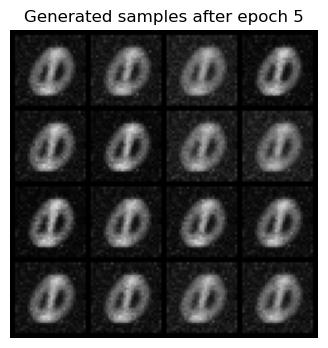

Epoch [6/20] Critic loss: -0.2710  Generator loss: 0.2351  Wasserstein estimate: 0.2710


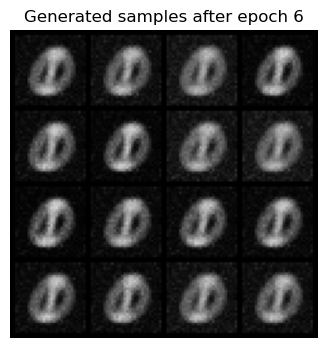

Epoch [7/20] Critic loss: -0.2100  Generator loss: 0.2739  Wasserstein estimate: 0.2100


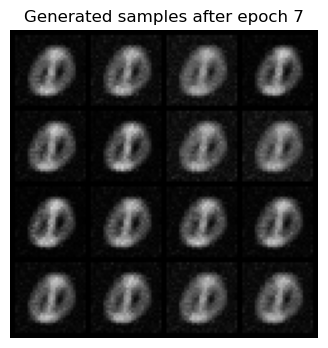

Epoch [8/20] Critic loss: -0.2192  Generator loss: 0.2440  Wasserstein estimate: 0.2192


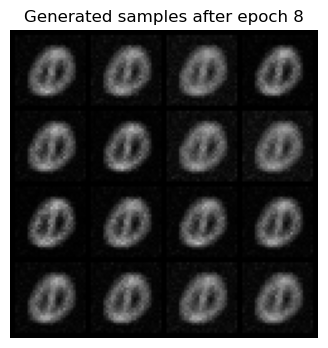

Epoch [9/20] Critic loss: -0.1499  Generator loss: 0.1782  Wasserstein estimate: 0.1499


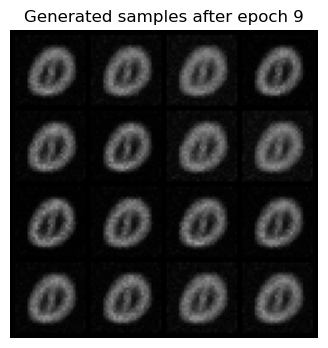

Epoch [10/20] Critic loss: -0.1783  Generator loss: 0.1604  Wasserstein estimate: 0.1783


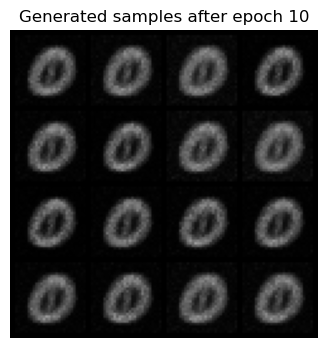

Epoch [11/20] Critic loss: -0.1665  Generator loss: 0.1545  Wasserstein estimate: 0.1665


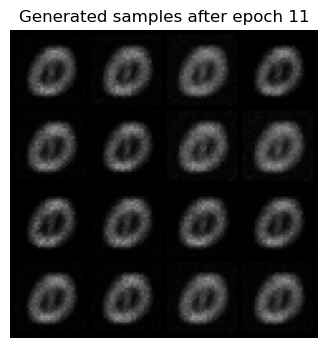

Epoch [12/20] Critic loss: -0.1598  Generator loss: 0.0848  Wasserstein estimate: 0.1598


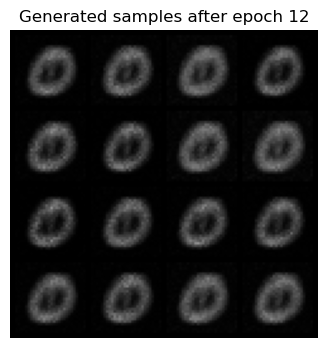

Epoch [13/20] Critic loss: -0.1615  Generator loss: 0.0564  Wasserstein estimate: 0.1615


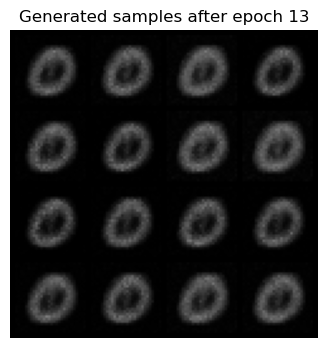

Epoch [14/20] Critic loss: -0.1445  Generator loss: 0.0362  Wasserstein estimate: 0.1445


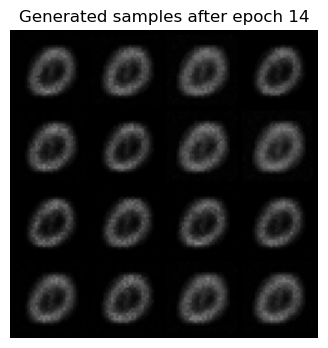

Epoch [15/20] Critic loss: -0.1307  Generator loss: 0.0230  Wasserstein estimate: 0.1307


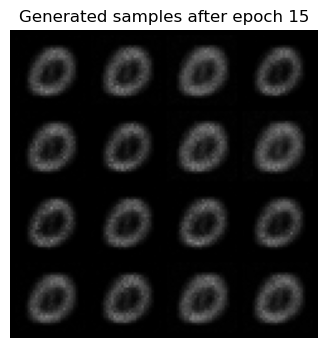

Epoch [16/20] Critic loss: -0.1483  Generator loss: 0.0342  Wasserstein estimate: 0.1483


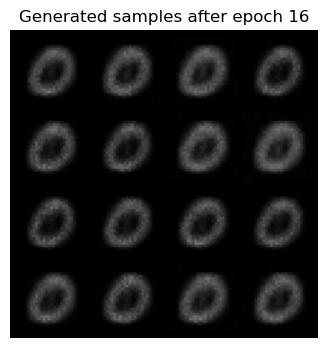

Epoch [17/20] Critic loss: -0.1505  Generator loss: 0.0105  Wasserstein estimate: 0.1505


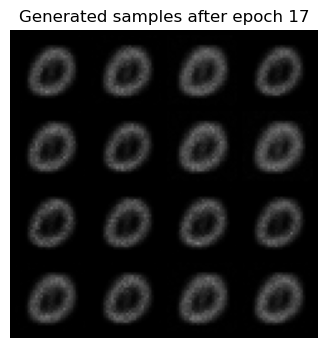

Epoch [18/20] Critic loss: -0.1481  Generator loss: 0.0029  Wasserstein estimate: 0.1481


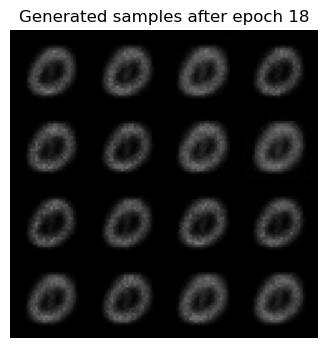

Epoch [19/20] Critic loss: -0.1327  Generator loss: 0.0009  Wasserstein estimate: 0.1327


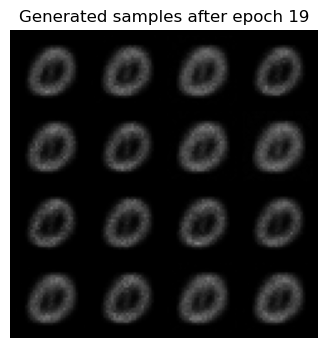

Epoch [20/20] Critic loss: -0.1382  Generator loss: -0.0014  Wasserstein estimate: 0.1382


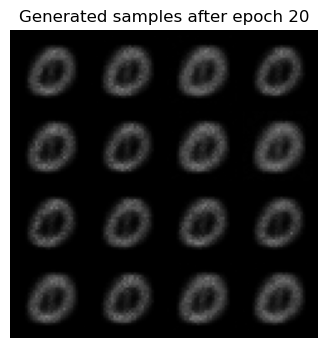

In [19]:
critic_losses = []
gen_losses = []
wass_estimates = []

fixed_z = sample_z(16, z_dim, device) 

for epoch in range(n_epochs):
    for i, (real_imgs, _) in enumerate(train_loader):

        # Update critic n_critic times
        for _ in range(n_critic):
            real_batch = real_imgs
            loss_c, w_est = critic_step(critic, generator, real_batch, opt_c, clip_value)
            critic_losses.append(loss_c)
            wass_estimates.append(w_est)

        # Update generator once
        loss_g = generator_step(critic, generator, opt_g, batch_size)
        gen_losses.append(loss_g)

    # Print some progress each epoch
    print(f"Epoch [{epoch+1}/{n_epochs}] "
          f"Critic loss: {loss_c:.4f}  "
          f"Generator loss: {loss_g:.4f}  "
          f"Wasserstein estimate: {w_est:.4f}")

    # Visualize samples at the end of each epoch 
    with torch.no_grad():
        fake_imgs = generator(fixed_z).cpu()
        grid = utils.make_grid(fake_imgs, nrow=4, padding=2)
        plt.figure(figsize=(4, 4))
        plt.imshow(grid.permute(1, 2, 0), cmap="gray")
        plt.axis("off")
        plt.title(f"Generated samples after epoch {epoch+1}")
        plt.show()


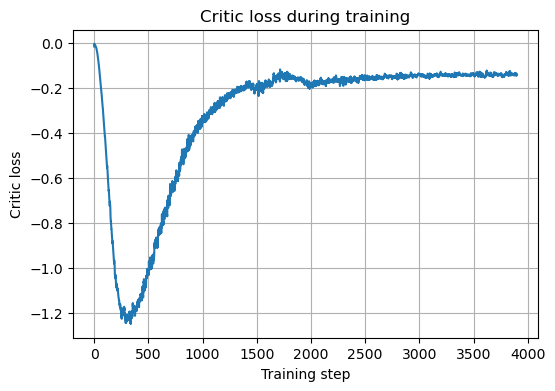

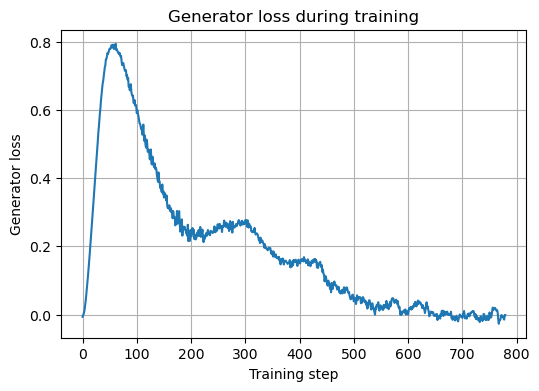

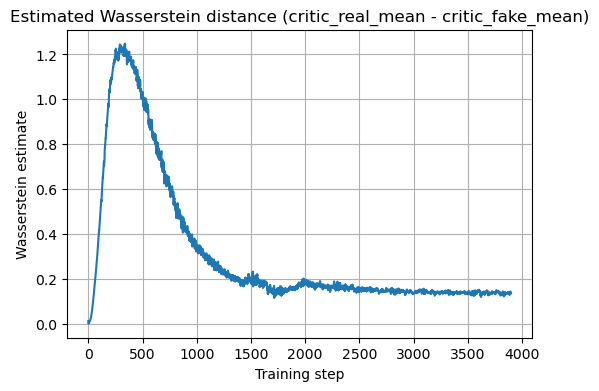

In [20]:
critic_losses_np = np.array(critic_losses)
gen_losses_np = np.array(gen_losses)
wass_np = np.array(wass_estimates)

plt.figure(figsize=(6, 4))
plt.plot(critic_losses_np)
plt.title("Critic loss during training")
plt.xlabel("Training step")
plt.ylabel("Critic loss")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(gen_losses_np)
plt.title("Generator loss during training")
plt.xlabel("Training step")
plt.ylabel("Generator loss")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(wass_np)
plt.title("Estimated Wasserstein distance (critic_real_mean - critic_fake_mean)")
plt.xlabel("Training step")
plt.ylabel("Wasserstein estimate")
plt.grid(True)
plt.show()


## Discussion of the Minimal CPU-ready WGAN Example

### Dataset

We used a small real-world dataset: MNIST digits 0 and 1.  
To keep the problem simple and CPU-friendly, we:
- Restricted to two classes (0 and 1) instead of all ten digits.
- Used only 5,000 training examples.

This makes the problem easier to train on a laptop and to visually inspect the generated images.

### Miniaturized WGAN Model

The original WGAN paper uses deeper, convolutional networks for high-resolution images.  
Here we implemented a very small MLP-based WGAN:

- **Generator**
  - Input: noise vector $z \in \mathbb{R}^{64}$ sampled from a standard normal distribution.
  - Two hidden layers of width 128 with ReLU activations.
  - Output: a 28×28 image (flattened to 784 and reshaped).
  - Final activation: Sigmoid, so that pixel intensities lie in \([0,1]\).

- **Critic**
  - Input: a 28×28 image, flattened to a 784-dimensional vector.
  - Two hidden layers of width 128 with LeakyReLU activations.
  - Output: a single real-valued score (no sigmoid).
  - This score approximates the 1-Lipschitz critic needed to estimate the Wasserstein distance.

The architecture is deliberately small so that it can be trained entirely on CPU in a reasonable time.

### Training Details

We followed the WGAN training procedure:

- Optimizer: RMSprop for both generator and critic.
- Learning rate: $5 \times 10^{-5}$.
- Number of critic steps per generator step: $n_{\text{critic}} = 5$.
- Weight clipping: after each critic update, all critic parameters are clipped to \([-0.01, 0.01]\) to enforce the Lipschitz constraint.

The loss functions are:

- **Critic loss** (negative of the Wasserstein estimate)

$$
L_D = -\left(
  \mathbb{E}_{x \sim P_r}[f(x)] - \mathbb{E}_{z \sim p(z)}[f(G(z))]
\right).
$$

- **Generator loss**
$$
  L_G = -\mathbb{E}_{z \sim p(z)}[f(G(z))].
$$

During training we logged:
- the critic loss,
- the generator loss,
- the estimated Wasserstein distance $\mathbb{E}_{x \sim P_r}[f(x)] - \mathbb{E}_{z \sim p(z)}[f(G(z))]$.


### Observations from the curves

- **Critic loss (Figure: "Critic loss during training")**  
  The critic loss quickly decreases to around \(-1.2\) in the first few hundred training steps, which means the critic rapidly learns to distinguish real from fake images.  
  After this initial phase, the loss slowly increases back towards values close to \(0\), stabilizing around \(-0.15\). This indicates that, as the generator improves, the critic finds it harder to separate real and generated samples, so the critic’s advantage is reduced.

- **Generator loss (Figure: "Generator loss during training")**  
  The generator loss initially increases and reaches a maximum of about \(0.8\). This happens when the critic is much stronger than the generator.  
  As training continues, the generator loss steadily decreases and eventually oscillates around values close to \(0\). This shows that the generator is learning to produce samples that receive higher scores from the critic, and that the game between the two networks is reaching a reasonably stable equilibrium.

- **Estimated Wasserstein distance (Figure: "Estimated Wasserstein distance")**  
  The estimated Wasserstein distance first rises to approximately \(1.2\): once the critic becomes powerful, it can clearly separate the initial (very poor) generator distribution from the real data.  
  After that peak, the distance steadily decreases and eventually flattens around \(0.15\). This decay indicates that the generator distribution is moving closer to the real data distribution. The final plateau suggests that the training has converged to a stable regime where the distance no longer changes significantly.

Overall, the three curves are smooth and monotonic in the long term (no wild oscillations or divergence). This is consistent with the qualitative behavior reported in the WGAN paper and shows one of the main advantages of the Wasserstein loss: the training process is more stable and the loss provides a meaningful signal throughout training.

### Conclusion

Even with a very small MLP on a reduced MNIST subset and CPU-only training, this minimal WGAN implementation:

- Demonstrates the key ideas of Wasserstein GANs:
  - A critic that outputs real-valued scores instead of probabilities.
  - A loss that approximates the Wasserstein distance between real and generated distributions.
  - A training procedure with multiple critic updates per generator update and weight clipping.
- Produces smooth, interpretable training curves:
  - the critic and generator losses evolve in a stable way,
  - the estimated Wasserstein distance first increases (as the critic improves) and then decreases (as the generator catches up).
- Generates samples whose quality improves as training progresses, in line with the behavior predicted by the theory.

This minimal example helps us understand the core principles of WGAN without the complexity of large convolutional architectures or GPU training.


### 5. Discussion: Weaknesses/limitations/future directions.

This project implements a minimal version of the original **Wasserstein GAN (WGAN)**. While the core idea (optimising a Wasserstein-based objective using a critic) leads to more stable gradients and a more meaningful training signal than a standard GAN, both the original formulation and our minimal implementation have important limitations.


#### 5.1 Limitations of the original WGAN formulation

**(1) Weight clipping provides a simple but imprecise approximation to the Lipschitz constraint.**

The original WGAN enforces the 1-Lipschitz constraint by **clipping critic weights** to a fixed interval \([-c, c]\). This is simple, but it can cause problems:

- If `clip_value` is too small, the critic becomes too constrained and **underfits**, producing weak gradients for the generator.
- If `clip_value` is too large, the critic may violate the Lipschitz condition and training may become **unstable**.

In practice, clipping often requires manual tuning and can lead to a critic that is not expressive enough to approximate the ideal Wasserstein critic.

**(2) Critic capacity and optimisation sensitivity**

WGAN stability depends on having a critic that is trained close enough to optimality at each step. This is why the algorithm uses several critic updates per generator update (`n_critic`). However:

- Choosing `n_critic` is not always straightforward.
- The critic can still be hard to train well if the architecture is too small or if hyperparameters are not appropriate.

So, while WGAN reduces some instabilities of classical GANs, it still remains **sensitive to architecture and hyperparameter choices**.

**(3) Later work improves the Lipschitz enforcement**

A major follow-up is **WGAN-GP**, which replaces weight clipping with a **gradient penalty**. This typically produces:

- smoother enforcement of Lipschitzness,
- a stronger critic,
- improved sample quality and training stability.

This highlights that the key limitation of the original WGAN is not the Wasserstein objective itself, but the practical way the Lipschitz constraint is enforced.


#### 5.2 Limitations of our minimal implementation

We have adopted a simplified implementation to ensure the experiment runs quickly on CPU and is easy to reproduce, which makes it easier to understand, but introduces additional limitations:

**(1) Very simple data distribution**

We train on a synthetic 2D distribution (a Gaussian blob). This is useful from a learning perspective, because we can clearly visualize learning and monitor the Wasserstein estimate, but it is far from real-world image generation and does not test the model under difficult high-dimensional conditions.

**(2) Small MLP architectures**

Both the generator and critic are simple MLPs. This is appropriate for a minimal example, but limits:

- the critic’s ability to approximate the optimal Wasserstein critic,
- the generator’s ability to represent complex distributions.

For images, convolutional architectures are typically needed to capture spatial structure.

**(3) Limited training budget and no quantitative evaluation**

We have ran a small number of iterations and do not compute metrics such as FID or Inception Score. As a result, our evaluation is mostly qualitative and based on:

- the behaviour of the Wasserstein estimate,
- the stability of losses,
- and (if applicable) visual inspection of generated samples.


#### 5.3 Future directions / possible improvements

There are several clear ways to improve and extend this project:

1. **Implement WGAN-GP (gradient penalty)**  
   Replace weight clipping with a gradient penalty term. This would likely make training more stable and produce a more reliable critic.

2. **Stronger architectures (especially for images)**  
   Use convolutional generator/critic networks (DCGAN-style). This would enable sharper and higher-quality samples on image datasets.

3. **Scaling to more complex datasets**  
   Move from a simple 2D toy distribution to MNIST/Fashion-MNIST/CIFAR-10 to test the method in higher dimensions where mode collapse and instability are more serious.

4. **Add quantitative evaluation**  
   Track objective metrics (e.g., FID) and compare:
   - a standard GAN baseline,
   - clipped WGAN,
   - WGAN-GP,
   under a consistent compute budget.


Overall, our project supports the main insight of the WGAN paper: using a critic to approximate a Wasserstein-based objective provides a more informative training signal than the original GAN loss. At the same time, it also highlights a key practical limitation of the original method: **weight clipping is an imperfect way to enforce the Lipschitz constraint**, motivating improved variants such as WGAN-GP.
